In [ ]:
import os
from pathlib import Path
import glob
import re
import numpy as np
import pandas as pd
import h5py
import torch
#import librosa
import ast
import string
import zipfile
from tqdm.notebook import tqdm
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import cv2
from moviepy.editor import VideoFileClip
import nibabel as nib
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
import ipywidgets as widgets
from ipywidgets import VBox, Dropdown, Button
from IPython.display import Video, display, clear_output
from transformers import BertTokenizer, BertModel
from torchvision.transforms import Compose, Lambda, CenterCrop
from torchvision.models.feature_extraction import create_feature_extractor
from pytorchvideo.transforms import Normalize, UniformTemporalSubsample, ShortSideScale
# Load the .mkv file

In [3]:
root_data_dir = './data/algonauts_2025.competitors'
# Select platform
platform = 'jupyter_notebook' #@param ['colab', 'jupyter_notebook']
initial_dir = os.getcwd() 
# Select device for computation
device = 'cpu' # @param ['cpu', 'cuda']

print(f'Running on "{platform}" using "{device}" device!')

Running on "jupyter_notebook" using "cpu" device!


In [4]:
# Open the fMRI responses file, and extract the specific dataset 
fmri_file_path = initial_dir + "/data/algonauts_2025.competitors/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
atlas_path = initial_dir + "/data/algonauts_2025.competitors/fmri/sub-01/atlas/sub-01_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz"
atlas_img = nib.load(atlas_path)
# Open the H5 file in read mode
with h5py.File(fmri_file_path, 'r') as file:
    print(f"Keys: {list(file.keys())}")
    a_group_key = list(file.keys())
    for i in a_group_key:  
        if "s01e02a" in i:
            print("Found: ", i)
            dataset_name = i
            break
    fmri_data = file[dataset_name][()]



Keys: ['ses-001_task-s01e02a', 'ses-001_task-s01e02b', 'ses-001_task-s01e03a', 'ses-001_task-s01e03b', 'ses-002_task-s01e04a', 'ses-002_task-s01e04b', 'ses-002_task-s01e05a', 'ses-002_task-s01e05b', 'ses-003_task-s01e01a', 'ses-003_task-s01e01b', 'ses-003_task-s01e06a', 'ses-003_task-s01e06b', 'ses-004_task-s01e07a', 'ses-004_task-s01e07b', 'ses-004_task-s01e08a', 'ses-004_task-s01e08b', 'ses-004_task-s01e09a', 'ses-004_task-s01e09b', 'ses-005_task-s01e10a', 'ses-005_task-s01e10b', 'ses-005_task-s01e11a', 'ses-005_task-s01e11b', 'ses-006_task-s01e12a', 'ses-006_task-s01e12b', 'ses-006_task-s01e13a', 'ses-006_task-s01e13b', 'ses-006_task-s01e14a', 'ses-006_task-s01e14b', 'ses-007_task-s01e15a', 'ses-007_task-s01e15b', 'ses-007_task-s01e16a', 'ses-007_task-s01e16b', 'ses-007_task-s01e17a', 'ses-007_task-s01e17b', 'ses-008_task-s01e18a', 'ses-008_task-s01e18b', 'ses-008_task-s01e19a', 'ses-008_task-s01e19b', 'ses-009_task-s01e20a', 'ses-009_task-s01e20b', 'ses-009_task-s01e21a', 'ses-009_

# audio features 

In [5]:
import torchaudio
from pathlib import Path

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)

def extract_audio_features(episode_path, tr,  device, save_dir_temp,
    save_dir_features):
    name_ep=episode_path.split('/')[-1].split('_')[-1].split('.')[0]
    # Get the onset time of each movie chunk
    clip = VideoFileClip(episode_path)
    start_times = [x for x in np.arange(0, clip.duration, tr)][:-1]
    # Create the directory where the movie chunks are temporarily saved
    temp_dir = os.path.join(save_dir_temp, 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    # Empty features list
    audio_features = []
    ### Loop over chunks ###
    with tqdm(total=len(start_times), desc="Extracting audio features") as pbar:
        for start in start_times:

            clip_chunk = clip.subclip(start, start+tr)
            chunk_audio_path = os.path.join(temp_dir, 'audio_s01e01a.wav')
            clip_chunk.audio.write_audiofile(chunk_audio_path, verbose=False,
                            logger=None)
            waveform, sample_rate = torchaudio.load(chunk_audio_path) 
            waveform = torch.mean(waveform, 0,True) # average the two channels of the wave files
            waveform = waveform.to(device)
            if sample_rate != bundle.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
            with torch.inference_mode():
                features, _ = model.extract_features(waveform)
                features = np.array(features, dtype='float32')
                # keep last layer() of the model
                features = features[11,:,:,:]
                features = np.mean(features,1) # average the time frames 
                audio_features.append(features)
 
                # Update the progress bar
                pbar.update(1)
    ### Convert the visual features to float32 ###
    audio_features = np.array(audio_features, dtype='float32')
    
    # Save the audio features
    out_file_audio = os.path.join(
        save_dir_features,name_ep+'_features_audio.h5')
    print(f"Saving audio features to {out_file_audio}")
    with h5py.File(out_file_audio, 'w' if Path(out_file_audio).exists() else 'w') as f:
        
        if name_ep+'_features_audio.h5' in f:
            group = f[name_ep]
        else:
            group = f.create_group(name_ep)
        if 'audio' in group:
            del group['audio']
        group.create_dataset('audio', data=np.asarray(audio_features), dtype=np.float32)
    print(f"Audio features saved to {out_file_audio}")


objc[69229]: Class AVFFrameReceiver is implemented in both /opt/anaconda3/envs/py39/lib/python3.9/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x30e7d03a8) and /opt/anaconda3/envs/py39/lib/libavdevice.59.7.100.dylib (0x3202e0778). One of the two will be used. Which one is undefined.
objc[69229]: Class AVFAudioReceiver is implemented in both /opt/anaconda3/envs/py39/lib/python3.9/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x30e7d03f8) and /opt/anaconda3/envs/py39/lib/libavdevice.59.7.100.dylib (0x3202e07c8). One of the two will be used. Which one is undefined.


In [6]:
def get_ep_path(documents_path):
    os.chdir("../algonauts_2025.competitors")
    paths=[glob.glob(os.path.join(documents_path, "*.mkv"))]
    return paths

In [7]:
# As an example, extract audio features using season 1, episode 1 of Friends

show_path =["/stimuli/movies/friends/","/stimuli/movies/movie10"]
documents_path = os.getcwd() +"/stimuli/movies/friends/s1"
episode_paths = get_ep_path(documents_path)
# Duration of each movie chunk, aligned with the fMRI TR of 1.49 seconds
tr = 1.49
# Saving directories
save_dir_temp = initial_dir+"/data/audio_features/"
save_dir_features = initial_dir+"/data/audio_features/friends_features/"
print(f"Saving audio features to {save_dir_features}")

# Execute audio feature extraction
for i in episode_paths[0][1:2]:
    extract_audio_features(i, tr, device,
        save_dir_temp, save_dir_features)

Saving audio features to /Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/audio_features/friends_features/


In [8]:
def load_audio_features(file_path):
    #with h5py.File(save_dir_features+'s01e09b_features_audio.h5', 'r') as f:
    with h5py.File(file_path, 'r') as f:
        print(f"Keys: {list(f.keys())}")
        list(f.keys())[0]
        key_ = list(f.keys())[0]
        print(f[key_])
        audio_data = f[key_]['audio'][()]
        print(f"Loaded audio features with shape: {audio_data.shape}")

    return audio_data

In [9]:
def define_frames_transform():
    """Defines the preprocessing pipeline for the video frames. Note that this
    transform is specific to the slow_r50 model."""
    transform = Compose(
        [
            UniformTemporalSubsample(8),
            Lambda(lambda x: x/255.0),
            Normalize([0.45, 0.45, 0.45], [0.225, 0.225, 0.225]),
            ShortSideScale(size=256),
            CenterCrop(256)
        ]
  )
    return transform

transform = define_frames_transform()

In [ ]:
def get_vision_model(device):
    """
    Load a pre-trained slow_r50 video model and set up the feature extractor.

    Parameters
    ----------
    device : torch.device
        The device on which the model will run (i.e., 'cpu' or 'cuda').

    Returns
    -------
    feature_extractor : torch.nn.Module
        The feature extractor model.
    model_layer : str
        The layer from which visual features will be extracted.

    """

    # Load the model
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50',
        pretrained=True)

    # Select 'blocks.5.pool' as the feature extractor layer
    model_layer = 'blocks.5.pool'
    feature_extractor = create_feature_extractor(model,
        return_nodes=[model_layer])
    feature_extractor.to(device)
    feature_extractor.eval()

    return feature_extractor, model_layer

feature_extractor, model_layer = get_vision_model(device)

Using cache found in /Users/genevievelam/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [ ]:
def extract_visual_features(episode_path, tr, feature_extractor, model_layer,
    transform, device, save_dir_temp, save_dir_features):
    """
    Extract visual features from a movie using a pre-trained video model.

    Parameters
    ----------
    episode_path : str
        Path to the movie file for which the visual features are extracted.
    tr : float
        Duration of each chunk, in seconds (aligned with the fMRI repetition
        time, or TR).
    feature_extractor : torch.nn.Module
        Pre-trained feature extractor model.
    model_layer : str
        The model layer from which the visual features are extracted.
    transform : torchvision.transforms.Compose
        Transformation pipeline for processing video frames.
    device : torch.device
        Device for computation ('cpu' or 'cuda').
    save_dir_temp : str
        Directory where the chunked movie clips are temporarily stored for
        feature extraction.
    save_dir_features : str
        Directory where the extracted visual features are saved.

    Returns
    -------
    visual_features : float
        Array containing the extracted visual features.

    """

    # Get the onset time of each movie chunk
    name_ep=episode_path.split('/')[-1].split('_')[-1].split('.')[0]
    clip = VideoFileClip(episode_path)
    start_times = [x for x in np.arange(0, clip.duration, tr)][:-1]
    # Create the directory where the movie chunks are temporarily saved
    temp_dir = os.path.join(save_dir_temp, 'temp')
    os.makedirs(temp_dir, exist_ok=True)

    # Empty features list
    visual_features = []

    # Loop over chunks
    with tqdm(total=len(start_times), desc="Extracting visual features") as pbar:
        for start in start_times:

            # Divide the movie in chunks of length TR, and save the resulting
            # clips as '.mp4' files
            clip_chunk = clip.subclip(start, start+tr)
            chunk_path = os.path.join(temp_dir, 'visual_chunk.mp4')
            clip_chunk.write_videofile(chunk_path, verbose=False, audio=False,
                logger=None)
            # Load the frames from the chunked movie clip
            video_clip = VideoFileClip(chunk_path)
            chunk_frames = [frame for frame in video_clip.iter_frames()]

            # Format the frames to shape:
            # (batch_size, channels, num_frames, height, width)
            frames_array = np.transpose(np.array(chunk_frames), (3, 0, 1, 2))
            # Convert the video frames to tensor
            inputs = torch.from_numpy(frames_array).float()
            # Preprocess the video frames
            inputs = transform(inputs).unsqueeze(0).to(device)

            # Extract the visual features
            with torch.no_grad():
                preds = feature_extractor(inputs)
            visual_features.append(np.reshape(preds[model_layer].cpu().numpy(), -1))

            # Update the progress bar
            pbar.update(1)

    # Convert the visual features to float32
    visual_features = np.array(visual_features, dtype='float32')

    # Save the visual features
    out_file_visual = os.path.join(
        save_dir_features, name_ep+'_features_visual.h5')
    with h5py.File(out_file_visual, 'a' if Path(out_file_visual).exists() else 'w') as f:
        group = f.create_group(name_ep)
        group.create_dataset('visual', data=visual_features, dtype=np.float32)
    print(f"Visual features saved to {out_file_visual}")

    # Output
    return visual_features

In [ ]:
# As an exemple, extract visual features for season 1, episode 1 of Friends
documents_path = os.getcwd() +"/stimuli/movies/friends/s1"
episode_paths = get_ep_path(documents_path)
# Duration of each movie chunk, aligned with the fMRI TR of 1.49 seconds
tr = 1.49
# Saving directories
save_dir_temp = initial_dir+"/data/visual_features/"
save_dir_features = initial_dir+"/data/visual_features/friends_features/"
print(f"Saving audio features to {save_dir_features}")

# Execute audio feature extraction
for i in episode_paths[0]:
    print(f"Processing {i}")
    extract_visual_features(i, tr, feature_extractor,
    model_layer, transform, device, save_dir_temp, save_dir_features)

Saving audio features to /Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/visual_features/friends_features/
Processing /Users/genevievelam/Documents/GitHub/algonauts_2025.competitors/stimuli/movies/friends/s1/friends_s01e09b.mkv


Extracting visual features:   0%|          | 0/467 [00:00<?, ?it/s]

Visual features saved to /Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/visual_features/friends_features/s01e09b_features_visual.h5


# choosing encodding paremeters 

In [10]:
subjects = [1,2,3,5]  #@param ["1", "2", "3", "5"] {type:"raw", allow-input: true}

modality = "all"  #@param ["visual", "audio", "language", "all"]

excluded_samples_start = 5  #@param {type:"slider", min:0, max:20, step:1}

excluded_samples_end = 1  #@param {type:"slider", min:0, max:20, step:1}

hrf_delay = 3  #@param {type:"slider", min:0, max:10, step:1}

stimulus_window = 8  #@param {type:"slider", min:1, max:20, step:1}

movies_train = ["friends-s01", "friends-s02", "friends-s03", "friends-s04", "friends-s05", "movie10-bourne", "movie10-figures", "movie10-life", "movie10-wolf"] # @param {allow-input: true}

movies_val = ["friends-s06"] # @param {allow-input: true}

# load stimulus features

In [12]:
def load_stimulus_features(root_data_dir, modality, train_test):
    """
    Load the stimulus features.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    modality : str
        Used feature modality.

    Returns
    -------
    features : dict
        Dictionary containing the stimulus features.

    """

    features = {}

    ### Load the visual features ###
    if modality == 'visual' or modality == 'all':
        stimuli_dir = os.path.join(root_data_dir,'stimulus_features', 'pca',
            'friends_movie10', 'visual', train_test)
        features['visual'] = np.load(stimuli_dir, allow_pickle=True).item()

    ### Load the audio features ###
    if modality == 'audio' or modality == 'all':
        stimuli_dir = os.path.join(root_data_dir,'stimulus_features', 'pca',
            'friends_movie10', 'audio', train_test)
        features['audio'] = np.load(stimuli_dir, allow_pickle=True).item()

    ### Load the language features ###
    if modality == 'language' or modality == 'all':
        stimuli_dir = os.path.join(root_data_dir, 'stimulus_features', 'pca',
            'friends_movie10', 'language', train_test)
        features['language'] = np.load(stimuli_dir, allow_pickle=True).item()

    ### Output ###
    return features

In [13]:
# Load the stimulus features
features = load_stimulus_features(initial_dir+"/data/algonauts_2025.competitors", modality,'features_train.npy')
# Print all available movie splits for each stimulus modality
"""
for key_modality, value_modality in features.items():
    print(f"\n{key_modality} features movie splits name and shape:")
    for key_movie, value_movie in value_modality.items():
        print(key_movie + " " + str(value_movie.shape))     
        """


'\nfor key_modality, value_modality in features.items():\n    print(f"\n{key_modality} features movie splits name and shape:")\n    for key_movie, value_movie in value_modality.items():\n        print(key_movie + " " + str(value_movie.shape))     \n        '

In [14]:
def load_fmri(root_data_dir, subject):
    """
    Load the fMRI responses for the selected subject.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    subject : int
        Subject used to train and validate the encoding model.

    Returns
    -------
    fmri : dict
        Dictionary containing the  fMRI responses.

    """

    fmri = {}

    ### Load the fMRI responses for Friends ###
    # Data directory
    fmri_file = f'sub-0{subject}_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5'
                            #'_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5'
    fmri_dir = os.path.join(root_data_dir,#,'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'func', fmri_file)
    # Load the the fMRI responses
    fmri_friends = h5py.File(fmri_dir, 'r')
    for key, val in fmri_friends.items():
        fmri[str(key[13:])] = val[:].astype(np.float32)
    del fmri_friends

    ### Load the fMRI responses for Movie10 ###
    # Data directory
    fmri_file = f'sub-0{subject}_task-movie10_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_bold.h5'
    fmri_dir = os.path.join(root_data_dir,#'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'func', fmri_file)
    # Load the the fMRI responses
    fmri_movie10 = h5py.File(fmri_dir, 'r')
    for key, val in fmri_movie10.items():
        fmri[key[13:]] = val[:].astype(np.float32)
    del fmri_movie10
    # Average the fMRI responses across the two repeats for 'figures'
    keys_all = fmri.keys()
    figures_splits = 12
    for s in range(figures_splits):
        movie = 'figures' + format(s+1, '02')
        keys_movie = [rep for rep in keys_all if movie in rep]
        fmri[movie] = ((fmri[keys_movie[0]] + fmri[keys_movie[1]]) / 2).astype(np.float32)
        del fmri[keys_movie[0]]
        del fmri[keys_movie[1]]
    # Average the fMRI responses across the two repeats for 'life'
    keys_all = fmri.keys()
    life_splits = 5
    for s in range(life_splits):
        movie = 'life' + format(s+1, '02')
        keys_movie = [rep for rep in keys_all if movie in rep]
        fmri[movie] = ((fmri[keys_movie[0]] + fmri[keys_movie[1]]) / 2).astype(np.float32)
        del fmri[keys_movie[0]]
        del fmri[keys_movie[1]]

    ### Output ###
    return fmri

os.chdir("../algonauts_2025.competitors")
dir= '/Users/genevievelam/Documents/GitHub/algonauts_2025.competitors/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5'


In [15]:
# Load the fMRI responses
fmri_subjects = {}
for subject in subjects:
    # Load the fMRI responses
    fmri = load_fmri('/Users/genevievelam/Documents/GitHub/algonauts_2025.competitors/', subject)
    fmri_subjects[subject] = fmri
"""
# Print all available movies
print(f"Subject {subject} fMRI movies splits name and shape:")
for key, value in fmri.items():
    print(key + " " + str(value.shape))
"""

'\n# Print all available movies\nprint(f"Subject {subject} fMRI movies splits name and shape:")\nfor key, value in fmri.items():\n    print(key + " " + str(value.shape))\n'

# finite impulse response (FIR)

In [16]:
def delays(X_train):
    delays= [1,2,3,4]
    n_samples, n_features = X_train.shape

    X_delayed = np.zeros((n_samples, n_features * len(delays)),
                        dtype=X_train.dtype)
    for idx, delay in enumerate(delays):
        beg, end = idx * n_features, (idx + 1) * n_features
        if delay == 0:
            X_delayed[:, beg:end] = X_train
        elif delay > 0:
            X_delayed[delay:, beg:end] = X_train[:-delay]
        elif delay < 0:
            X_delayed[:-abs(delay), beg:end] = X_train[abs(delay):]
            
    return X_delayed


# Aligning the visual and audio features with the fMRI data

In [17]:
def align_features_and_fmri_samples(features, fmri, excluded_samples_start,
    excluded_samples_end, hrf_delay, stimulus_window, movies):
    """
    Align the stimulus feature with the fMRI response samples for the selected
    movies, later used to train and validate the encoding models.

    Parameters
    ----------
    features : dict
        Dictionary containing the stimulus features.
    fmri : dict
        Dictionary containing the fMRI responses.
    excluded_trs_start : int
        Integer indicating the first N fMRI TRs that will be excluded and not
        used for model training. The reason for excluding these TRs is that due
        to the latency of the hemodynamic response the fMRI responses of first
        few fMRI TRs do not yet contain stimulus-related information.
    excluded_trs_end : int
        Integer indicating the last N fMRI TRs that will be excluded and not
        used for model training. The reason for excluding these TRs is that
        stimulus feature samples (i.e., the stimulus chunks) can be shorter than
        the fMRI samples (i.e., the fMRI TRs), since in some cases the fMRI run
        ran longer than the actual movie. However, keep in mind that the fMRI
        timeseries onset is ALWAYS SYNCHRONIZED with movie onset (i.e., the
        first fMRI TR is always synchronized with the first stimulus chunk).
    hrf_delay : int
        fMRI detects the BOLD (Blood Oxygen Level Dependent) response, a signal
        that reflects changes in blood oxygenation levels in response to
        activity in the brain. Blood flow increases to a given brain region in
        response to its activity. This vascular response, which follows the
        hemodynamic response function (HRF), takes time. Typically, the HRF
        peaks around 5–6 seconds after a neural event: this delay reflects the
        time needed for blood oxygenation changes to propagate and for the fMRI
        signal to capture them. Therefore, this parameter introduces a delay
        between stimulus chunks and fMRI samples for a better correspondence
        between input stimuli and the brain response. For example, with a
        hrf_delay of 3, if the stimulus chunk of interest is 17, the
        corresponding fMRI sample will be 20.
    stimulus_window : int
        Integer indicating how many stimulus features' chunks are used to model
        each fMRI TR, starting from the chunk corresponding to the TR of
        interest, and going back in time. For example, with a stimulus_window of
        5, if the fMRI TR of interest is 20, it will be modeled with stimulus
        chunks [16, 17, 18, 19, 20]. Note that this only applies to visual and
        audio features, since the language features were already extracted using
        transcript words spanning several movie chunks (thus, each fMRI TR will
        only be modeled using the corresponding language feature chunk). Also
        note that a larger stimulus window will increase compute time, since it
        increases the amount of stimulus features used to train and test the
        fMRI encoding models.
    movies: list
        List of strings indicating the movies for which the fMRI responses and
        stimulus features are aligned, out of the first six seasons of Friends
        ["friends-s01", "friends-s02", "friends-s03", "friends-s04",
        "friends-s05", "friends-s06"], and the four movies from Movie10
        ["movie10-bourne", "movie10-figures", "movie10-life", "movie10-wolf"].

    Returns
    -------
    aligned_features : float
        Aligned stimulus features for the selected movies.
    aligned_fmri : float
        Aligned fMRI responses for the selected movies.

    """

    ### Empty data variables ###
    aligned_features = []
    aligned_fmri = np.empty((0,1000), dtype=np.float32)

    ### Loop across movies ###
    for movie in movies:

        ### Get the IDs of all movies splits for the selected movie ###
        if movie[:7] == 'friends':
            id = movie[8:]
        elif movie[:7] == 'movie10':
            id = movie[8:]
        movie_splits = [key for key in fmri if id in key[:len(id)]]

        ### Loop over movie splits ###
        for split in movie_splits:

            ### Extract the fMRI ###
            fmri_split = fmri[split]
            # Exclude the first and last fMRI samples
            fmri_split = fmri_split[excluded_samples_start:-excluded_samples_end]
            aligned_fmri = np.append(aligned_fmri, fmri_split, 0)

            ### Loop over fMRI samples ###
            for s in range(len(fmri_split)):
                # Empty variable containing the stimulus features of all
                # modalities for each fMRI sample
                f_all = np.empty(0)

                ### Loop across modalities ###
                for mod in features.keys():

                    ### Visual and audio features ###
                    # If visual or audio modality, model each fMRI sample using
                    # the N stimulus feature samples up to the fMRI sample of
                    # interest minus the hrf_delay (where N is defined by the
                    # 'stimulus_window' variable)
                    if mod == 'visual' or mod == 'audio':
                        # In case there are not N stimulus feature samples up to
                        # the fMRI sample of interest minus the hrf_delay (where
                        # N is defined by the 'stimulus_window' variable), model
                        # the fMRI sample using the first N stimulus feature
                        # samples
                        if s < (stimulus_window + hrf_delay):
                            idx_start = excluded_samples_start
                            idx_end = idx_start + stimulus_window
                        else:
                            idx_start = s + excluded_samples_start - hrf_delay \
                                - stimulus_window + 1
                            idx_end = idx_start + stimulus_window
                        # In case there are less visual/audio feature samples
                        # than fMRI samples minus the hrf_delay, use the last N
                        # visual/audio feature samples available (where N is
                        # defined by the 'stimulus_window' variable)
                        if idx_end > (len(features[mod][split])):
                            idx_end = len(features[mod][split])
                            idx_start = idx_end - stimulus_window
                        f = features[mod][split][idx_start:idx_end]
                        f_all = np.append(f_all, f.flatten())

                    ### Language features ###
                    # Since language features already consist of embeddings
                    # spanning several samples, only model each fMRI sample
                    # using the corresponding stimulus feature sample minus the
                    # hrf_delay
                    elif mod == 'language':
                        # In case there are no language features for the fMRI
                        # sample of interest minus the hrf_delay, model the fMRI
                        # sample using the first language feature sample
                        if s < hrf_delay:
                            idx = excluded_samples_start
                        else:
                            idx = s + excluded_samples_start - hrf_delay
                        # In case there are fewer language feature samples than
                        # fMRI samples minus the hrf_delay, use the last
                        # language feature sample available
                        if idx >= (len(features[mod][split]) - hrf_delay):
                            f = features[mod][split][-1,:]
                        else:
                            f = features[mod][split][idx]
                        f_all = np.append(f_all, f.flatten())

                 ### Append the stimulus features of all modalities for this sample ###
                aligned_features.append(f_all)

    ### Convert the aligned features to a numpy array ###
    aligned_features = np.asarray(aligned_features, dtype=np.float32)

    ### Output ###
    return aligned_features, aligned_fmri

excluded_samples_start = 5  #@param {type:"slider", min:0, max:20, step:1}

excluded_samples_end = 1  #@param {type:"slider", min:0, max:20, step:1}

hrf_delay = 3  #@param {type:"slider", min:0, max:10, step:1}

stimulus_window = 8  #@param {type:"slider", min:1, max:20, step:1}

In [18]:
for i in subjects:
    features_train, fmri_train = align_features_and_fmri_samples(features, fmri_subjects[i],
        excluded_samples_start, excluded_samples_end, hrf_delay,  stimulus_window,
        movies_train)
    if i == 1:
        features_train_all=features_train
        fmri_train_all=fmri_train
    else:
        features_train_all=np.concatenate((features_train_all, features_train), axis=0)
        fmri_train_all=np.concatenate((fmri_train_all,fmri_train), dtype=np.float32)

# Print the shape of the training fMRI responses and stimulus features: note
# that the two have the same sample size!
print("Training fMRI responses shape:")
print(fmri_train_all.shape)
print('(Train samples × Parcels)')
print("\nTraining stimulus features shape:")
print(features_train_all.shape)
print('(Train samples × Features)')

Training fMRI responses shape:
(520824, 1000)
(Train samples × Parcels)

Training stimulus features shape:
(520824, 2410)
(Train samples × Features)


In [19]:
excluded_samples_start = 5  #@param {type:"slider", min:0, max:20, step:1}

excluded_samples_end = 1  #@param {type:"slider", min:0, max:20, step:1}

hrf_delay = 4  #@param {type:"slider", min:0, max:10, step:1}

stimulus_window = 5  #@param {type:"slider", min:1, max:20, step:1}

In [20]:
for i in subjects:
    features_train, fmri_train = align_features_and_fmri_samples(features, fmri_subjects[i],
        excluded_samples_start, excluded_samples_end, hrf_delay,  stimulus_window,
        movies_train)
    if i == 1:
        features_train_all_1=features_train
        fmri_train_all_1=fmri_train
    else:
        features_train_all_1=np.concatenate((features_train_all_1, features_train), axis=0)
        fmri_train_all_1=np.concatenate((fmri_train_all_1,fmri_train), dtype=np.float32)

# Print the shape of the training fMRI responses and stimulus features: note
# that the two have the same sample size!
print("Training fMRI responses shape:")
print(fmri_train_all_1.shape)
print('(Train samples × Parcels)')
print("\nTraining stimulus features shape:")
print(features_train_all_1.shape)
print('(Train samples × Features)')

Training fMRI responses shape:
(520824, 1000)
(Train samples × Parcels)

Training stimulus features shape:
(520824, 1600)
(Train samples × Features)


In [ ]:
np.save('test3.npy', a)    # .npy extension is added if not given
d = np.load('test3.npy')

In [21]:
def pad(features_train_all_1,features_train_all):
    if len(features_train_all_1[0]) < len(features_train_all[0]):
        N=len(features_train_all[0]) - len(features_train_all_1[0])
        n_samples, n_features = features_train_all_1.shape
        X_delayed = np.zeros((n_samples, 1 * N),
                                dtype=features_train_all_1.dtype)
        if X_delayed is not None:
            result = np.concatenate((features_train_all_1, X_delayed), axis=1)
        return  np.concatenate((features_train_all, result), axis=0, dtype=np.float32)
    elif len(features_train_all_1[0]) > len(features_train_all[0]):
        N=len(features_train_all_1[0])-len(features_train_all[0])
        n_samples, n_features = features_train_all.shape
        X_delayed = np.zeros((n_samples, 1 * N),
                                dtype=features_train_all.dtype)
        if X_delayed is not None:
            result = np.concatenate((features_train_all, X_delayed), axis=1)

        return np.concatenate(( result,features_train_all_1), axis=0, dtype=np.float32)
    else: 
        return np.concatenate(( features_train_all,features_train_all_1), axis=0, dtype=np.float32)

In [22]:
features_train_con=pad(features_train_all_1,features_train_all)

In [23]:
features_train_con.shape

(1041648, 2410)

In [24]:
fmri_train_all_con=np.concatenate(( fmri_train_all,fmri_train_all_1), axis=0, dtype=np.float32)

In [25]:
fmri_train_all_con.shape

(1041648, 1000)

In [ ]:
from sklearn.linear_model import LogisticRegression
def train_encoding(features_train, fmri_train):
    """
    Train a linear-regression-based encoding model to predict fMRI responses
    using movie features.

    Parameters
    ----------
    features_train : float
        Stimulus features for the training movies.
    fmri_train : float
        fMRI responses for the training movies.

    Returns
    -------
    model : object
        Trained regression model.

    """

    ### Train the linear regression model ###
    #model = LinearRegression().fit(features_train, fmri_train)

    # instantiate the model (using the default parameters)
    model = Ridge(random_state=16)

    # fit the model with data
    model.fit(features_train, fmri_train)
    #from sklearn.ensemble import RandomForestRegressor
    #model = RandomForestRegressor(random_state=0)
    #model.fit(features_train, fmri_train)

    ### Output ###
    return model

: 

In [ ]:
# Train the encoding model
model = train_encoding(features_train_con, fmri_train_all_con)

# Remove unused variables from memory
#del features_train, fmri_train

In [96]:
from joblib import dump, load
dump(model, initial_dir + "/data/algonauts_2025.competitors/filename.joblib") 
#clf = load( initial_dir + "/data/algonauts_2025.competitors/filename.joblib") 
#clf.predict(features_val_all[1])

['/Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/algonauts_2025.competitors/filename.joblib']

In [255]:
# Align the stimulus features with the fMRI responses for the validation movies
features_val_all = {}
fmri_val_all = {}
for i in [1]:
    features_val, fmri_val = align_features_and_fmri_samples(features, fmri_subjects[1],
        excluded_samples_start, excluded_samples_end, stimulus_window,
        movies_val)
    #features_val=delays(features_val)
    features_val_all[i]=features_val
    fmri_val_all[i]= fmri_val


# Remove unused variables from memory
#del features, fmri

# Print the shape of the test fMRI responses and stimulus features: note
# that the two have the same sample size!
print("Validation fMRI responses shape:", fmri_val_all[1].shape)
print('(Validation samples × Parcels)')
print("\nValidation stimulus features shape:", features_val_all[1].shape)
print('(Validation samples × Features)')

Validation fMRI responses shape: (0, 1000)
(Validation samples × Parcels)

Validation stimulus features shape: (0,)
(Validation samples × Features)


In [254]:
# Predict the fMRI responses for the validation movies
predictions = {}
for i in [1]:
    fmri_val_pred = model.predict(features_val_all[i])
    predictions[i] = fmri_val_pred

# Print the shape of the recorded and predicted test fMRI responses: note that
# the two have the same shape!
print("Validation fMRI responses shape:", fmri_val_all[i].shape)
print('(Validation samples × Parcels)')
print("\nValidation predicted fMRI responses shape:", predictions[i].shape)
print('(Validation samples × Parcels)')

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [81]:
def compute_encoding_accuracy(fmri_val, fmri_val_pred, subject, modality):
    """
    Compare the  recorded (ground truth) and predicted fMRI responses, using a
    Pearson's correlation. The comparison is perfomed independently for each
    fMRI parcel. The correlation results are then plotted on a glass brain.

    Parameters
    ----------
    fmri_val : float
        fMRI responses for the validation movies.
    fmri_val_pred : float
        Predicted fMRI responses for the validation movies
    subject : int
        Subject number used to train and validate the encoding model.
    modality : str
        Feature modality used to train and validate the encoding model.

    """

    ### Correlate recorded and predicted fMRI responses ###
    encoding_accuracy = np.zeros((fmri_val.shape[1]), dtype=np.float32)
    for p in range(len(encoding_accuracy)):
        encoding_accuracy[p] = pearsonr(fmri_val[:, p],
            fmri_val_pred[:, p])[0]
    mean_encoding_accuracy = np.round(np.mean(encoding_accuracy), 3)

    ### Map the prediction accuracy onto a 3D brain atlas for plotting ###
    atlas_file = f'sub-0{subject}_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz'
    atlas_path = os.path.join(initial_dir, 'data', 'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'atlas', atlas_file)
    atlas_masker = NiftiLabelsMasker(labels_img=atlas_path)
    atlas_masker.fit()
    encoding_accuracy_nii = atlas_masker.inverse_transform(encoding_accuracy)

    ### Plot the encoding accuracy ###
    title = f"Encoding accuracy, sub-0{subject}, modality-{modality}, mean accuracy: " + str(mean_encoding_accuracy)
    display = plotting.plot_glass_brain(
        encoding_accuracy_nii,
        display_mode="lyrz",
        cmap='hot_r',
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=False,
        title=title
    )
    colorbar = display._cbar
    colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)
    plotting.show()



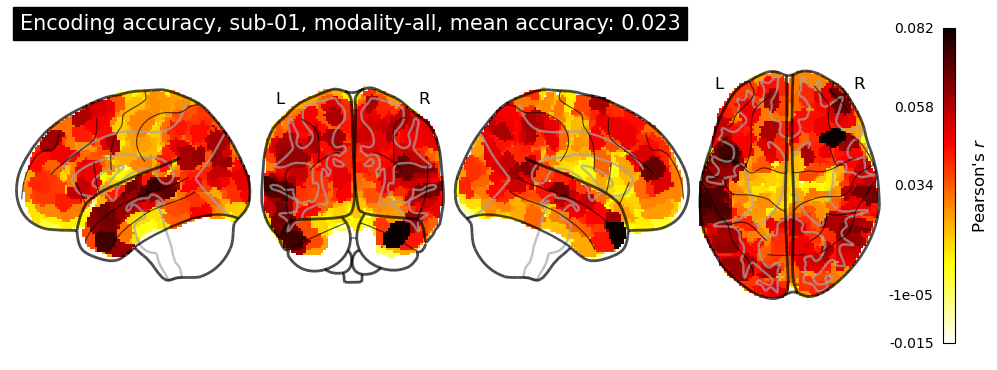

In [181]:
compute_encoding_accuracy(fmri_val_all[1], predictions[1], 1, modality)

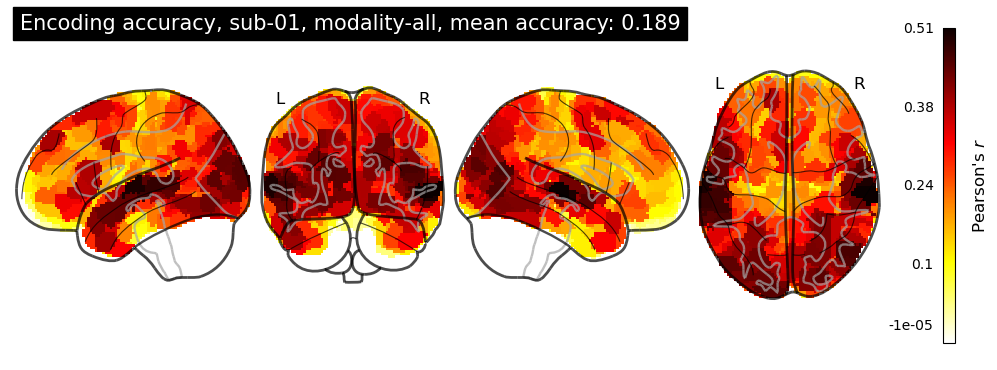

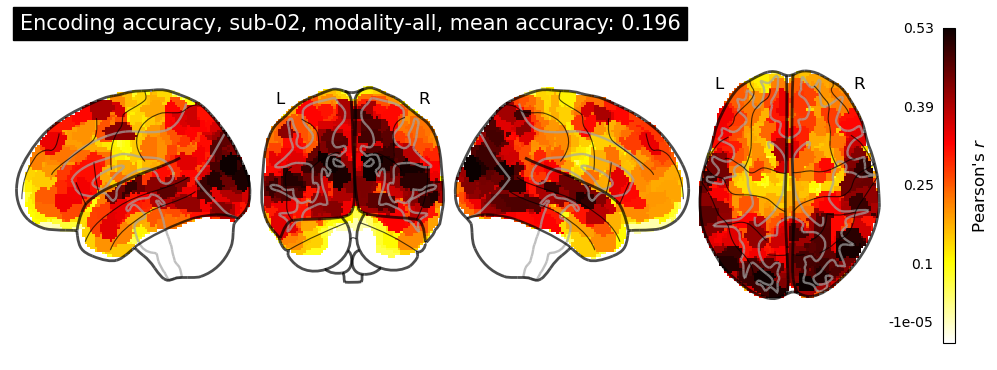

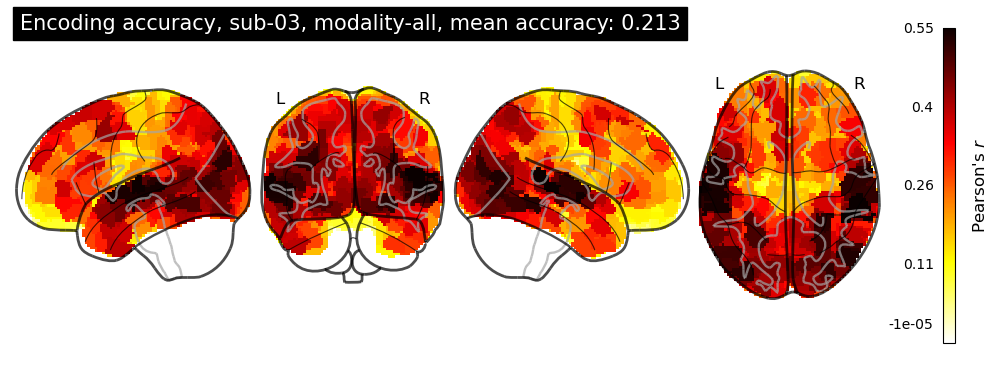

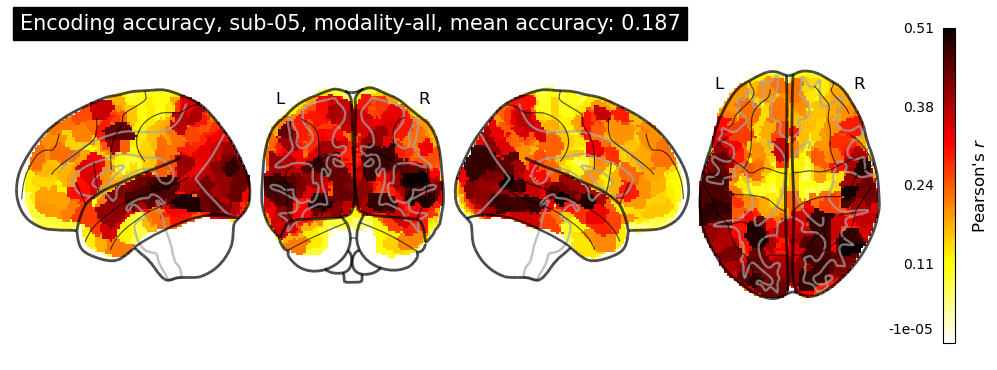

In [83]:
for i in subjects:
    subject = i
    fmri_val = fmri_val_all[i]
    fmri_val_pred = predictions[i]
    # Compute the encoding accuracy
    compute_encoding_accuracy(fmri_val, fmri_val_pred, subject, modality)

In [113]:
(0.189+0.187+0.213+0.196)/4

0.19624999999999998

# preparing submit s7

In [ ]:
def align_features_and_fmri_samples_friends_s7(features_friends_s7,
    root_data_dir):
    """
    Align the stimulus feature with the fMRI response samples for Friends season
    7 episodes, later used to predict the fMRI responses for challenge
    submission.

    Parameters
    ----------
    features_friends_s7 : dict
        Dictionary containing the stimulus features for Friends season 7.
    root_data_dir : str
        Root data directory.

    Returns
    -------
    aligned_features_friends_s7 : dict
        Aligned stimulus features for each subject and Friends season 7 episode.

    """

    ### Empty results dictionary ###
    aligned_features_friends_s7 = {}

    ### HRF delay ###
    # fMRI detects the BOLD (Blood Oxygen Level Dependent) response, a signal
    # that reflects changes in blood oxygenation levels in response to activity
    # in the brain. Blood flow increases to a given brain region in response to
    # its activity. This vascular response, which follows the hemodynamic
    # response function (HRF), takes time. Typically, the HRF peaks around 5–6
    # seconds after a neural event: this delay reflects the time needed for
    # blood oxygenation changes to propagate and for the fMRI signal to capture
    # them. Therefore, this parameter introduces a delay between stimulus chunks
    # and fMRI samples for a better correspondence between input stimuli and the
    # brain response. For example, with a hrf_delay of 3, if the stimulus chunk
    # of interest is 17, the corresponding fMRI sample will be 20.
    hrf_delay = 3

    ### Stimulus window ###
    # stimulus_window indicates how many stimulus feature samples are used to
    # model each fMRI sample, starting from the stimulus sample corresponding to
    # the fMRI sample of interest, minus the hrf_delay, and going back in time.
    # For example, with a stimulus_window of 5, and a hrf_delay of 3, if the
    # fMRI sample of interest is 20, it will be modeled with stimulus samples
    # [13, 14, 15, 16, 17]. Note that this only applies to visual and audio
    # features, since the language features were already extracted using
    # transcript words spanning several movie samples (thus, each fMRI sample
    # will only be modeled using the corresponding language feature sample,
    # minus the hrf_delay). Also note that a larger stimulus window will
    # increase compute time, since it increases the amount of stimulus features
    # used to train and validate the fMRI encoding models. Here you will use a
    # value of 5, since this is how the challenge baseline encoding models were
    # trained.
    stimulus_window = 5

    ### Loop over subjects ###
    subjects = [1, 2, 3, 5]
    desc = "Aligning stimulus and fMRI features of the four subjects"
    for sub in tqdm(subjects, desc=desc):
        aligned_features_friends_s7[f'sub-0{sub}'] = {}

        ### Load the Friends season 7 fMRI samples ###
        samples_dir = os.path.join(root_data_dir, 'algonauts_2025.competitors',
            'fmri', f'sub-0{sub}', 'target_sample_number',
            f'sub-0{sub}_friends-s7_fmri_samples.npy')
        fmri_samples = np.load(samples_dir, allow_pickle=True).item()

        ### Loop over Friends season 7 episodes ###
        for epi, samples in fmri_samples.items():
            features_epi = []

            ### Loop over fMRI samples ###
            for s in range(samples):
                # Empty variable containing the stimulus features of all
                # modalities for each sample
                f_all = np.empty(0)

                ### Loop across modalities ###
                for mod in features_friends_s7.keys():

                    ### Visual and audio features ###
                    # If visual or audio modality, model each fMRI sample using
                    # the N stimulus feature samples up to the fMRI sample of
                    # interest minus the hrf_delay (where N is defined by the
                    # 'stimulus_window' variable)
                    if mod == 'visual' or mod == 'audio':
                        # In case there are not N stimulus feature samples up to
                        # the fMRI sample of interest minus the hrf_delay (where
                        # N is defined by the 'stimulus_window' variable), model
                        # the fMRI sample using the first N stimulus feature
                        # samples
                        if s < (stimulus_window + hrf_delay):
                            idx_start = 0
                            idx_end = idx_start + stimulus_window
                        else:
                            idx_start = s - hrf_delay - stimulus_window + 1
                            idx_end = idx_start + stimulus_window
                        # In case there are less visual/audio feature samples
                        # than fMRI samples minus the hrf_delay, use the last N
                        # visual/audio feature samples available (where N is
                        # defined by the 'stimulus_window' variable)
                        if idx_end > len(features_friends_s7[mod][epi]):
                            idx_end = len(features_friends_s7[mod][epi])
                            idx_start = idx_end - stimulus_window
                        f = features_friends_s7[mod][epi][idx_start:idx_end]
                        f_all = np.append(f_all, f.flatten())

                    ### Language features ###
                    # Since language features already consist of embeddings
                    # spanning several samples, only model each fMRI sample
                    # using the corresponding stimulus feature sample minus the
                    # hrf_delay
                    elif mod == 'language':
                        # In case there are no language features for the fMRI
                        # sample of interest minus the hrf_delay, model the fMRI
                        # sample using the first language feature sample
                        if s < hrf_delay:
                            idx = 0
                        else:
                            idx = s - hrf_delay
                        # In case there are fewer language feature samples than
                        # fMRI samples minus the hrf_delay, use the last
                        # language feature sample available
                        if idx >= (len(features_friends_s7[mod][epi]) - hrf_delay):
                            f = features_friends_s7[mod][epi][-1,:]
                        else:
                            f = features_friends_s7[mod][epi][idx]
                        f_all = np.append(f_all, f.flatten())

                ### Append the stimulus features of all modalities for this sample ###
                features_epi.append(f_all)

            ### Add the episode stimulus features to the features dictionary ###
            aligned_features_friends_s7[f'sub-0{sub}'][epi] = np.asarray(
                features_epi, dtype=np.float32)

    return aligned_features_friends_s7

In [99]:
features_friends_s7  = load_stimulus_features(initial_dir+"/data/algonauts_2025.competitors", modality,'features_test.npy')  

In [106]:
# Align the stimulus features with the fMRI responses for Friends season 7
aligned_features_friends_s7 = align_features_and_fmri_samples_friends_s7(
    features_friends_s7,stimulus_window,hrf_delay)

# As an example, print the shape of the stimulus features of one episode for
# each subject
for key, val in aligned_features_friends_s7.items():
    episode_name = "s07e01a"
    example_episode_shape = val[episode_name].shape
    print(f"Subject: {key}")
    print(f"  Episode: {episode_name} - Features shape: {example_episode_shape}")
    print("-" * 40)

Aligning stimulus and fMRI features of the four subjects:   0%|          | 0/4 [00:00<?, ?it/s]

Subject: sub-01
  Episode: s07e01a - Features shape: (460, 2600)
----------------------------------------
Subject: sub-02
  Episode: s07e01a - Features shape: (460, 2600)
----------------------------------------
Subject: sub-03
  Episode: s07e01a - Features shape: (460, 2600)
----------------------------------------
Subject: sub-05
  Episode: s07e01a - Features shape: (460, 2600)
----------------------------------------


In [107]:
# Empty submission predictions dictionary
submission_predictions = {}

# Loop through each subject
desc = "Predicting fMRI responses of each subject"
for sub, features in tqdm(aligned_features_friends_s7.items(), desc=desc):

    # Initialize the nested dictionary for each subject's predictions
    submission_predictions[sub] = {}

    # Loop through each Friends season 7 episode
    for epi, feat_epi in features.items():

        # Predict fMRI responses for the aligned features of this episode, and
        # convert the predictions to float32
        fmri_pred = model.predict(feat_epi).astype(np.float32)

        # Store formatted predictions in the nested dictionary
        submission_predictions[sub][epi] = fmri_pred

Predicting fMRI responses of each subject:   0%|          | 0/4 [00:00<?, ?it/s]

In [108]:
# Display the structure and shapes of the predicted fMRI responses dictionary
for subject, episodes_dict in submission_predictions.items():
    # Print the subject and episode number for Friends season 7
    print(f"Subject: {subject}")
    print(f"  Number of Episodes: {len(episodes_dict)}")
    # Print the predicted fMRI response shape for each episode
    for episode, predictions in episodes_dict.items():
        print(f"    - Episode: {episode}, Predicted fMRI shape: {predictions.shape}")
    print("-" * 40)  # Separator for clarity

Subject: sub-01
  Number of Episodes: 49
    - Episode: s07e01a, Predicted fMRI shape: (460, 1000)
    - Episode: s07e01b, Predicted fMRI shape: (494, 1000)
    - Episode: s07e02a, Predicted fMRI shape: (492, 1000)
    - Episode: s07e02b, Predicted fMRI shape: (526, 1000)
    - Episode: s07e03a, Predicted fMRI shape: (417, 1000)
    - Episode: s07e03b, Predicted fMRI shape: (452, 1000)
    - Episode: s07e04a, Predicted fMRI shape: (447, 1000)
    - Episode: s07e04b, Predicted fMRI shape: (482, 1000)
    - Episode: s07e05a, Predicted fMRI shape: (454, 1000)
    - Episode: s07e05b, Predicted fMRI shape: (488, 1000)
    - Episode: s07e06a, Predicted fMRI shape: (478, 1000)
    - Episode: s07e06b, Predicted fMRI shape: (513, 1000)
    - Episode: s07e07a, Predicted fMRI shape: (473, 1000)
    - Episode: s07e07b, Predicted fMRI shape: (507, 1000)
    - Episode: s07e08a, Predicted fMRI shape: (474, 1000)
    - Episode: s07e08b, Predicted fMRI shape: (509, 1000)
    - Episode: s07e09a, Predict

In [ ]:
# Select the saving directory
save_dir = initial_dir+'/data' #@param {type:"string"}

# Save the predicted fMRI dictionary as a .npy file
output_file = save_dir + "/fmri_predictions_friends_s7.npy"
np.save(output_file, submission_predictions)
print(f"Formatted predictions saved to: {output_file}")

# Zip the saved file for submission
zip_file = save_dir + "/fmri_predictions_friends_s7_FIR.zip"
with zipfile.ZipFile(zip_file, 'w') as zipf:
    zipf.write(output_file, os.path.basename(output_file))
print(f"Submission file successfully zipped as: {zip_file}")

Formatted predictions saved to: /Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/fmri_predictions_friends_s7.npy
Submission file successfully zipped as: /Users/genevievelam/Documents/GitHub/algonauts_2025_challenge/data/fmri_predictions_friends_s7_.zip
